In [1]:
#@title 1. Setup
#@markdown Just run this cell as is. ***Don't modify the code block.*** The setup should not take more than two minutes. 
!pip uninstall -q -y tensorflow 
!pip install -q tf-nightly

from IPython.display import clear_output
import matplotlib.pyplot as plt
import tensorflow as tf
 
!pip install wandb -qq
import wandb
wandb.login(anonymous='allow')
clear_output()
content_image = None # This needs to be in global scope

print('You are all set!')

You are all set!


In [14]:
#@title 2. Choose a style image from the options below
from tensorflow import keras

STYLE_IMAGE_NAME = 'IMAGE_3' #@param ['IMAGE_1', 'IMAGE_2', 'IMAGE_3', 'IMAGE_4', 'IMAGE_5']

corresponding_url = {
    'IMAGE_1': 'https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg',
    'IMAGE_2': 'https://storage.googleapis.com/khanhlvg-public.appspot.com/arbitrary-style-transfer/style23.jpg',
    'IMAGE_3': 'https://upload.wikimedia.org/wikipedia/commons/thumb/a/a5/Tsunami_by_hokusai_19th_century.jpg/1024px-Tsunami_by_hokusai_19th_century.jpg',
    'IMAGE_4': 'https://upload.wikimedia.org/wikipedia/commons/thumb/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg/800px-Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg',
    'IMAGE_5': 'https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/757px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg'
}

style_image_path = keras.utils.get_file(STYLE_IMAGE_NAME + ".jpg", corresponding_url[STYLE_IMAGE_NAME])
print("Style image downloaded!")

278528/266637 [===============================] - 0s 0us/step
Style image downloaded!


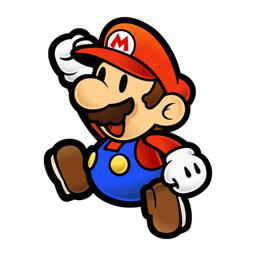

In [15]:
#@title 3. Upload an image you want to stylize
from IPython.display import display
import ipywidgets as widgets
from PIL import Image
import numpy as np
import io

clear_output()

def button_click(change):
    global content_image
    print('\n')
    img = Image.open(io.BytesIO(uploader.data[-1]))
    content_image = img
    img = img.convert('RGB')
    img.thumbnail((256, 256))
    img.save('thumbnail.jpg')
    image = Image.open('thumbnail.jpg')
    display(image)
    
uploader = widgets.FileUpload()
show_button = widgets.Button(description='Show image')
show_button.on_click(button_click)

widgets.VBox([widgets.Label('Upload a content image (must be an RGB or RGBA image). High-res images might take more time to be processed.'), uploader, show_button])

In [16]:
#@title 4. Load the images
#@markdown ***Don't modify this code block.***
# Function to load an image from a file, and add a batch dimension.
def load_img(path_to_img):
    img = tf.io.read_file(path_to_img)
    img = tf.io.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = img[tf.newaxis, :]

    return img

# Function to load an image from a file, and add a batch dimension.
def load_content_img(image_pixels):
    if image_pixels.shape[-1] == 4:
        image_pixels = Image.fromarray(image_pixels)
        img = image_pixels.convert('RGB')
        img = np.array(img)
        img = tf.convert_to_tensor(img)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = img[tf.newaxis, :]
        return img
    elif image_pixels.shape[-1] == 3:
        img = tf.convert_to_tensor(image_pixels)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = img[tf.newaxis, :]
        return img
    elif image_pixels.shape[-1] == 1:
        raise Error('Grayscale images not supported! Please try with RGB or RGBA images.')
    print('Exception not thrown')

# Function to pre-process by resizing an central cropping it.
def preprocess_image(image, target_dim):
    # Resize the image so that the shorter dimension becomes 256px.
    shape = tf.cast(tf.shape(image)[1:-1], tf.float32)
    short_dim = min(shape)
    scale = target_dim / short_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    image = tf.image.resize(image, new_shape)

    # Central crop the image.
    image = tf.image.resize_with_crop_or_pad(image, target_dim, target_dim)

    return image

# Convert the content image from Bytes to NumPy array.
content_image = np.array(content_image)

# Load the input images.
content_image = load_content_img(content_image)
style_image = load_img(style_image_path)
print('Images loaded up!')

Images loaded up!


In [17]:
#@title 5. Download the style transfer networks from TF Hub
#@markdown ***Don't modify this code block.***
#@markdown 

# Download the style bottleneck and transfer networks
print('Downloading the model files...')

style_predict_path = tf.keras.utils.get_file('style_predict.tflite', 'https://tfhub.dev/sayakpaul/lite-model/arbitrary-image-stylization-inceptionv3-dynamic-shapes/int8/predict/1?lite-format=tflite')
style_transform_path = style_transform_path = tf.keras.utils.get_file('style_transform.tflite', 'https://tfhub.dev/sayakpaul/lite-model/arbitrary-image-stylization-inceptionv3-dynamic-shapes/int8/transfer/1?lite-format=tflite')

print('Model files downloaded...')

Model files downloaded...


Preprocessing the style and the content images...
Style image shape: (1, 256, 256, 3)
Content image shape: (1, 257, 257, 3)
Calculating style bottleneck...
Style Bottleneck Shape: (1, 1, 1, 100)
Stylizing image. It should not take more than three minutes...


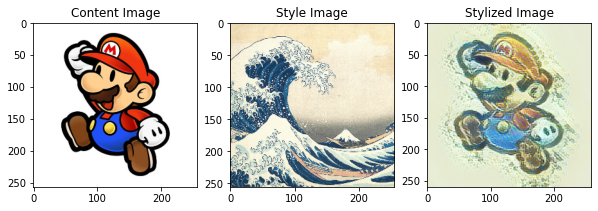

In [18]:
#@title 6. Stylize image

content_blending_ratio = 0 #@param {type:"slider", min:0, max:1, step:0.1}
#@markdown You're encouraged to play with the different values of `content_blending_ratio`.

content_image_size = 257 #@param {type:"slider", min:192, max:512, step:1}

# Preprocess the input images.
preprocessed_content_image = preprocess_image(content_image, content_image_size)
preprocessed_style_image = preprocess_image(style_image, 256)

print('Preprocessing the style and the content images...')
print('Style image shape:', preprocessed_style_image.shape)
print('Content image shape:', preprocessed_content_image.shape)

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
imshow(preprocessed_content_image, 'Content Image')

plt.subplot(1, 3, 2)
imshow(preprocessed_style_image, 'Style Image')

# Function to run style prediction on preprocessed style image.
def run_style_predict(preprocessed_style_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_predict_path)

  # Set model input.
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  interpreter.set_tensor(input_details[0]["index"], preprocessed_style_image)

  # Calculate style bottleneck.
  interpreter.invoke()
  style_bottleneck = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return style_bottleneck

# Calculate style bottleneck for the preprocessed style image.
print('Calculating style bottleneck...')
style_bottleneck = run_style_predict(preprocessed_style_image)
print('Style Bottleneck Shape:', style_bottleneck.shape)
print('Stylizing image. It should not take more than three minutes...')

# Run style transform on preprocessed style image
def run_style_transform(style_bottleneck, preprocessed_content_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_transform_path)

  # Set model input.
  input_details = interpreter.get_input_details()
  for index in range(len(input_details)):
    if input_details[index]["name"]=='content_image':
      index = input_details[index]["index"]
      interpreter.resize_tensor_input(index, [1, content_image_size, content_image_size, 3])
  interpreter.allocate_tensors()

  # Set model inputs.
  for index in range(len(input_details)):
    if input_details[index]["name"]=='Conv/BiasAdd':
      interpreter.set_tensor(input_details[index]["index"], style_bottleneck)
    elif input_details[index]["name"]=='content_image':
      interpreter.set_tensor(input_details[index]["index"], preprocessed_content_image)
  interpreter.invoke()

  # Transform content image.
  stylized_image = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return stylized_image

# Calculate style bottleneck of the content image.
style_bottleneck_content = run_style_predict(
    preprocess_image(content_image, 256)
)

# Blend the style bottleneck of style image and content image
style_bottleneck_blended = content_blending_ratio * style_bottleneck_content \
                           + (1 - content_blending_ratio) * style_bottleneck

# Stylize the content image using the style bottleneck.
stylized_image = run_style_transform(style_bottleneck_blended, preprocessed_content_image)

# Visualize the output.
plt.subplot(1, 3, 3)
imshow(stylized_image, 'Stylized Image')